<a href="https://colab.research.google.com/github/ferrysany/cuny604/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUNY 604 2021 Summer Project - Chun San Yip

Procurement Process Simulation

In [1]:
# download modsim.py if necessary

try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *

In [32]:
# import functions from modsim

from modsim import *
import matplotlib.pyplot as plt
import numpy as np

This project is build on the top of the customer check out example of Allen Downey 

The team has 5 buyers

The average number of Purchase Order per week is about 60.

The estimated process time for each Purchase Orders is 6 to 8 hours.

In [3]:
""" This function is to generate a system
lam is the incoming rate
mu is the process rate
duration is the simulation time (5 days or 2400 minutes)
"""

def PO_system(lam, mu, n):
      
  return System(lam=lam, mu=mu, n=n, duration=2400)

In [4]:
""" As day is the unit of the simulation
As there are 60 Purchase Order per 5 days or there are 12 Purchase Order per day
or 1 Purchase Order every 0.667 hours
The service time is about 6 hours """

interarrival_time = 40
service_time = 360

lam = 1/interarrival_time
mu = 1/service_time
n=5

system = PO_system(lam=lam, mu=mu, n=n)
system

System(duration=2400, lam=0.025, mu=0.002777777777777778, n=5)

In [5]:
""" 
x - the total number of Purchase Orders in the queue, including the Purchase 
    Orders being processed
t - the number of minutes that have elapsed in the simulation
Only 1 queue for this update function
n - number of buyer
If all buyers are busy, check whether the last is complete
"""

def update_func_one(x, t, system):

  for i in reversed(range(system.n)):   
          
    if x > i-1:
      if flip(system.mu):
        x -= 1
  
  if flip(system.lam):
    x += 1

  return x

In [6]:
def run_simulation(system, update_func_one):
    """Simulate a queueing system.
    
    system: System object
    update_func_one: function object
    """
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration):
        x = update_func_one(x, t, system)
        results[t+1] = x

    return results


In [7]:
def multiple_buyer(n): 

  for i in range(n):
    system = PO_system(lam=lam, mu=mu, n=(i+1))
    results = run_simulation(system, update_func_one)
    results.plot(label=str(i+1)+' Buyers')

  decorate(title='Purchase Order Processing',
            xlabel='Time (mins)',
            ylabel='Number of Purchase Order in the Queue')

  return

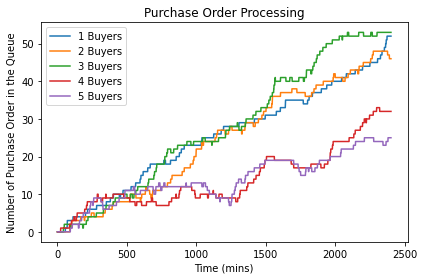

In [8]:
multiple_buyer(5)

The larger number of buyers, the lower the number of Purchase Order in the queue.
The diagram makes sense as more buyers work on the Purchase Order.

After the simulation, I also want to make use of Little's Law to find out the time Purchase Order is pending in the queue, W

We can compute L, which is the average number of Purchse Order in the system,
L=λW

Where λ is the arrival rate. Here's a function that computes them.


In [9]:
def compute_metrics(results, system):
    """Compute average number of Purchase Order and the pending time in the system.
    
    results: TimeSeries of queue lengths
    system: System object
    
    returns: L, W
    """
    L = results.mean()
    W = L / system.lam
    return L, W

In [13]:
"""
"""
results=run_simulation(system, update_func_one)
compute_metrics(results, system)

(13.9496253122398, 557.9850124895919)

The average number of Purchase Orders in the system is about 14.

The amount of pending time is 9.3 Hours

As the actual incoming Purchase Order fluctuates along the year, I would like to sweep the incoming rate from 0.5 to 0.9 of process rate.

The sweep_lam function will run to find out the relationship between process rate to the average time Purchase Order pending in the system.



In [29]:
lam_array = linspace(0.025, 0.25, 101)

In [30]:
def sweep_lam(lam_array, mu, update_func):

  sweep = SweepSeries()

  for lam in lam_array:
    system = PO_system(lam=lam, mu=mu, n=5) 
    results = run_simulation(system, update_func)
    L, W=compute_metrics(results, system)
    sweep[lam]=W
  
  return sweep


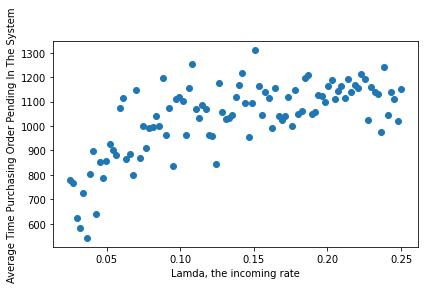

In [31]:
sweep_lam_result = sweep_lam(lam_array, mu, update_func_one)
plt.scatter(sweep_lam_result.index, sweep_lam_result)
decorate(xlabel='Lamda, the incoming rate',
         ylabel='Average Time Purchasing Order Pending In The System')